Package Installation and Imports

In [2]:
# Install necessary libraries
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade
!pip install -Uqq duckduckgo_search --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.0 MB/s eta 0:00:00


In [3]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.7.18
Fastcore version: 1.7.29


In [4]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from duckduckgo_search import DDGS
from fastcore.all import *

In [87]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term, safesearch='moderate')
        image_urls = [result.get("image") for result in search_results if result.get("image")]
        return L(image_urls[:max_images])

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/

mongolian_foods  mongolian_foods_classifier.pkl  PSET1.ipynb


In [90]:
# Change directory to your working directory
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [91]:
# Define the types of Mongolian traditional foods
food_types = 'buuz','khuushuur','tsuivan','bansh'
path = Path('mongolian_foods')

In [92]:
# Create directories for each food type
if not path.exists():
    path.mkdir()
    for food in food_types:
        dest = (path/food)
        dest.mkdir(exist_ok=True)
        urls = search_images(f'{food} Mongolian dumpling', max_images=50)
        download_images(dest, urls=urls)

In [93]:
# Verify and clean up images
fns = get_image_files(path)
failed = verify_images(fns)
print(f"Failed images: {len(failed)}")
failed.map(Path.unlink)

Failed images: 0


(#0) []

In [94]:
# Remove images that do not match the category manually
for food in food_types:
    food_path = path/food
    for img in get_image_files(food_path):
        try:
            with Image.open(img) as im:
                im.verify()
        except:
            img.unlink()

In [95]:
# Define DataBlock
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

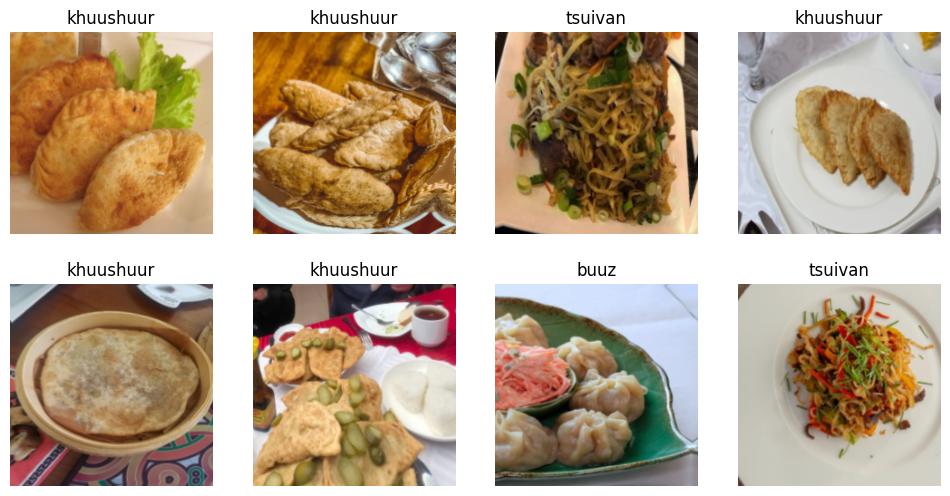

In [96]:
# Create DataLoaders
dls = foods.dataloaders(path)
dls.show_batch(max_n=8, nrows=2)

In [97]:
# Train the model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.535595,3.065072,0.640000,00:25


epoch,train_loss,valid_loss,error_rate,time
0,2.326368,2.458239,0.640000,00:30
1,2.307911,1.705426,0.640000,00:33
2,2.070943,1.111804,0.480000,00:36
3,1.729860,0.792939,0.360000,00:30
4,1.507101,0.683107,0.240000,00:30
5,1.365430,0.683395,0.240000,00:29


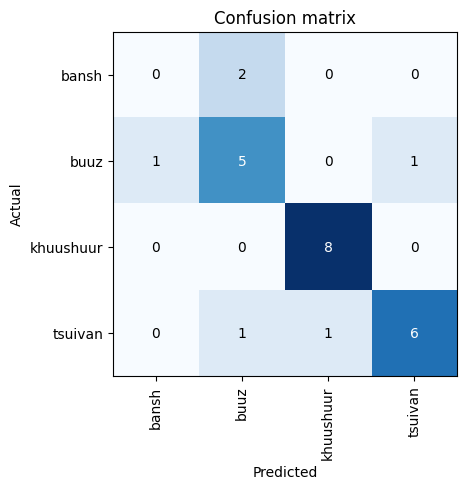

In [98]:
# Interpret the results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

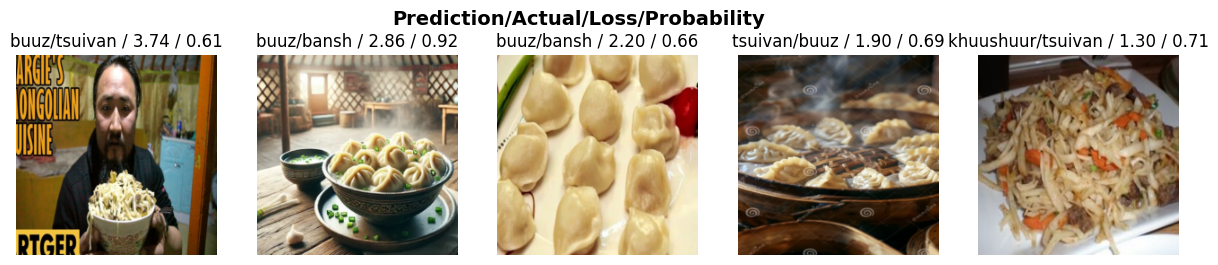

In [99]:
interp.plot_top_losses(5, nrows=1)

In [100]:
# Clean up misclassified images
cleaner = ImageClassifierCleaner(learn)
cleaner

In [101]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [102]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [103]:
dls = foods.dataloaders(path, bs=32)  # Adjust batch size if needed

In [104]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.304212,2.006709,0.680000,00:30


epoch,train_loss,valid_loss,error_rate,time
0,1.487934,1.305860,0.600000,00:38
1,1.136056,0.698274,0.360000,00:39
2,0.909151,0.571598,0.280000,00:39
3,0.738875,0.559931,0.280000,00:39


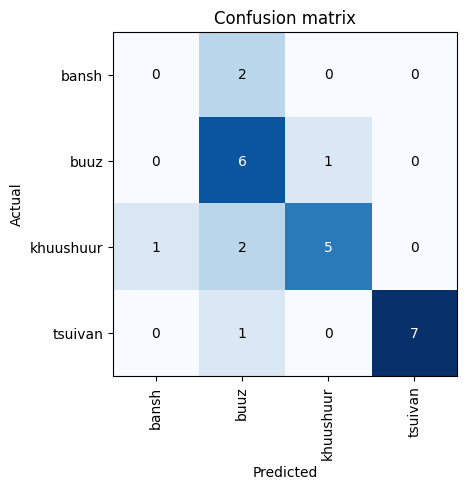

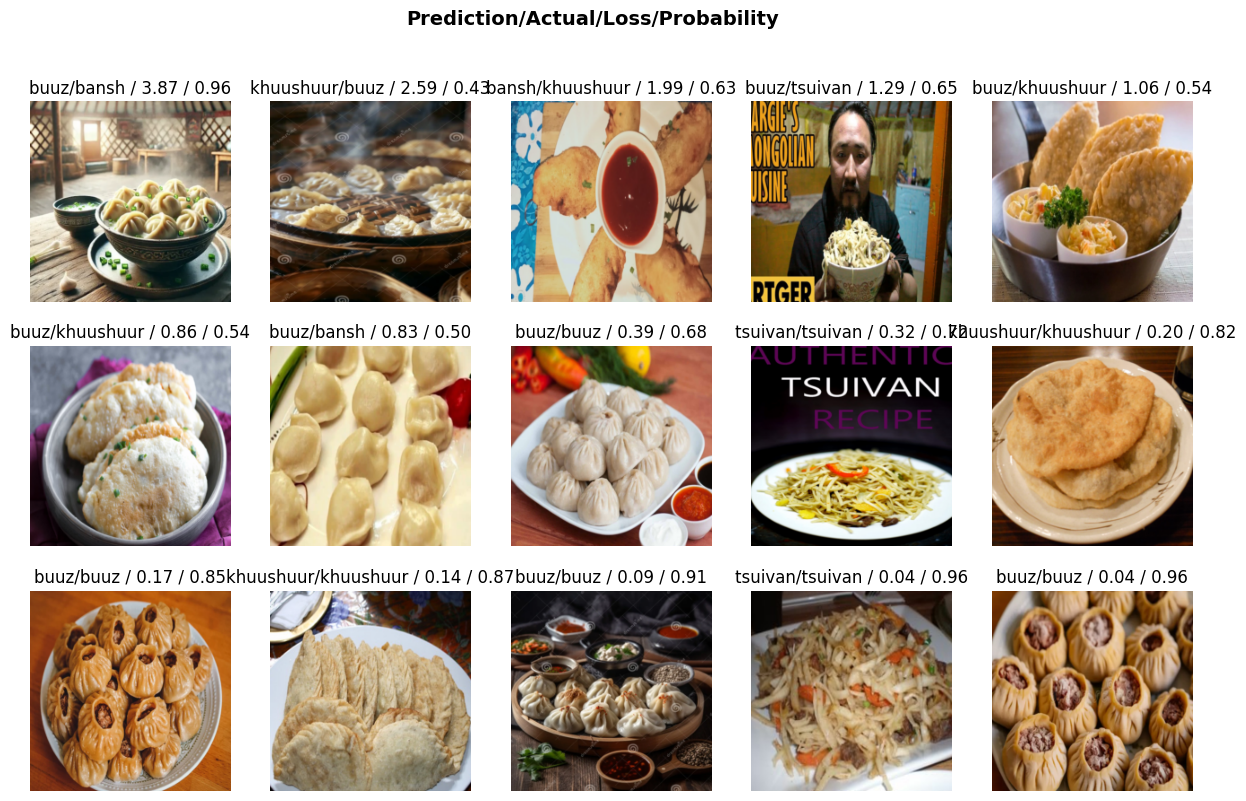

In [105]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(15, nrows=3)

# Save the final trained model
learn.export('mongolian_foods_classifier.pkl')
